In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 700

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['train']),
                            ImageFolder('/content/fer_ckplus', data_transforms['train'])])
val_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['val']),
                            ImageFolder('/content/fer_ckplus', data_transforms['val'])])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.datasets[0].targets + train_data.datasets[1].targets,
    stratify=train_data.datasets[0].targets + train_data.datasets[1].targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.models.mnasnet import _get_depths, _InvertedResidual, _stack, _round_to_multiple_of

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/mnasnet.html
_BN_MOMENTUM = 1 - 0.9997

class MNASNet(torch.nn.Module):
    # Version 2 adds depth scaling in the initial stages of the network.
    _version = 2

    def __init__(self, alpha: float, num_classes: int = 7, dropout: float = 0.2) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if alpha <= 0.0:
            raise ValueError(f"alpha should be greater than 0.0 instead of {alpha}")
        self.alpha = alpha
        self.num_classes = num_classes
        depths = _get_depths(alpha)
        layers = [
            # First layer: regular conv.
            nn.Conv2d(1, depths[0], 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            # Depthwise separable, no skip.
            nn.Conv2d(depths[0], depths[0], 3, padding=1, stride=1, groups=depths[0], bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(depths[0], depths[1], 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(depths[1], momentum=_BN_MOMENTUM),
            # MNASNet blocks: stacks of inverted residuals.
            _stack(depths[1], depths[2], 3, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[2], depths[3], 5, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[3], depths[4], 5, 2, 6, 3, _BN_MOMENTUM),
            _stack(depths[4], depths[5], 3, 1, 6, 2, _BN_MOMENTUM),
            _stack(depths[5], depths[6], 5, 2, 6, 4, _BN_MOMENTUM),
            _stack(depths[6], depths[7], 3, 1, 6, 1, _BN_MOMENTUM),
            # Final mapping to classifier input.
            nn.Conv2d(depths[7], 1280, 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280, momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
        ]
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.Dropout(p=dropout, inplace=True), nn.Linear(1280, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity="sigmoid")
                nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        # Equivalent to global avgpool and removing H and W dimensions.
        x = x.mean([2, 3])
        return self.classifier(x)

In [ ]:
model = MNASNet(1.0, 7)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 70
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             288
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9           [-1, 48, 32, 32]             768
      BatchNorm2d-10           [-1, 48, 32, 32]              96
             ReLU-11           [-1, 48, 32, 32]               0
           Conv2d-12           [-1, 48, 16, 16]             432
      BatchNorm2d-13           [-1, 48, 16, 16]              96
             ReLU-14           [-1, 48,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 6.1618, val_loss: 1.9047, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 4.0161, val_loss: 1.8834, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 2.8318, val_loss: 1.8300, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 2.4314, val_loss: 1.8946, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 2.3175, val_loss: 1.8970, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 2.2350, val_loss: 1.9145, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 2.2507, val_loss: 1.9242, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 2.1927, val_loss: 1.9899, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 2.2001, val_loss: 1.9516, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 2.1578, val_loss: 1.9309, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 2.0626, val_loss: 1.8360, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 1.9843, val_loss: 1.8821, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 1.8116, val_loss: 1.8813, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 1.6324, val_loss: 1.8962, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 1.5502, val_loss: 1.8923, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 1.4782, val_loss: 1.8869, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 1.4079, val_loss: 1.8927, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 1.5139, val_loss: 1.8947, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 1.4821, val_loss: 1.8750, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 1.3834, val_loss: 1.8760, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 1.3451, val_loss: 1.8805, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 1.3074, val_loss: 1.8873, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 1.2776, val_loss: 1.8914, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 1.2195, val_loss: 1.8817, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 1.3317, val_loss: 1.8599, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 1.4739, val_loss: 1.8589, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 1.3948, val_loss: 1.8240, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 1.2066, val_loss: 1.8473, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 1.1504, val_loss: 1.8451, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 1.1248, val_loss: 1.8218, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 1.1691, val_loss: 1.6970, val_acc: 0.1840


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 1.1121, val_loss: 1.7672, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 1.0694, val_loss: 1.7649, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 1.0518, val_loss: 1.7963, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 1.0689, val_loss: 1.8200, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 1.0154, val_loss: 1.8964, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 1.0446, val_loss: 2.0056, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 1.0103, val_loss: 1.9142, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 1.0390, val_loss: 1.8038, val_acc: 0.1441


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.9714, val_loss: 1.9298, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00064, train_loss: 0.9563, val_loss: 1.9131, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00061, train_loss: 0.9466, val_loss: 2.0149, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00058, train_loss: 0.9298, val_loss: 2.1477, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00055, train_loss: 0.9330, val_loss: 2.0920, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00052, train_loss: 0.9181, val_loss: 2.1347, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00048, train_loss: 0.9041, val_loss: 2.1706, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00045, train_loss: 0.8908, val_loss: 2.2499, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00042, train_loss: 0.8752, val_loss: 2.3195, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00039, train_loss: 0.8714, val_loss: 2.1956, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00036, train_loss: 0.8580, val_loss: 2.2342, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00033, train_loss: 0.8473, val_loss: 2.2581, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00030, train_loss: 0.8319, val_loss: 2.1259, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00027, train_loss: 0.8234, val_loss: 2.1078, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00024, train_loss: 0.8206, val_loss: 2.2381, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00021, train_loss: 0.8047, val_loss: 2.1190, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00019, train_loss: 0.7950, val_loss: 2.0312, val_acc: 0.1540


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00016, train_loss: 0.7883, val_loss: 2.0317, val_acc: 0.1478


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00014, train_loss: 0.7824, val_loss: 1.9692, val_acc: 0.1689


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00012, train_loss: 0.7722, val_loss: 1.8692, val_acc: 0.1801


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00010, train_loss: 0.7665, val_loss: 1.8392, val_acc: 0.1789


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00008, train_loss: 0.7587, val_loss: 1.7405, val_acc: 0.2171
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00006, train_loss: 0.7477, val_loss: 1.5686, val_acc: 0.2399


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00005, train_loss: 0.7478, val_loss: 1.4837, val_acc: 0.2965


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00004, train_loss: 0.7425, val_loss: 1.3645, val_acc: 0.3367


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00003, train_loss: 0.7366, val_loss: 1.2643, val_acc: 0.3981


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00002, train_loss: 0.7345, val_loss: 1.1544, val_acc: 0.4429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00001, train_loss: 0.7359, val_loss: 1.0607, val_acc: 0.4598


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00000, train_loss: 0.7323, val_loss: 1.0146, val_acc: 0.4913


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00000, train_loss: 0.7317, val_loss: 0.9315, val_acc: 0.5411


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00000, train_loss: 0.7313, val_loss: 0.8735, val_acc: 0.5656
Training complete in 69m 4s
Best val Acc: 0.565579


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5327 , roc: 0.9094 , f1: 0.4586 , recall: 0.4711


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.5861 , roc: 0.9401 , f1: 0.6246 , recall: 0.7237


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/mnasnetraf.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.18402921555095467, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14409937888198757, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14

In [ ]:
results = {'acc': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.18402921555095467, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14409937888198757, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.15403726708074533, 0.14782608695652175, 0.168944099378882, 0.18012422360248448, 0.17888198757763973, 0.21709633828681854, 0.23990842494828227, 0.29647686551632374, 0.3367240000104933, 0.3981063756155622, 0.44291949107573136, 0.4597754314629188, 0.4913169214004388, 0.5411497851171659, 0.5655793796819151], 'f1': [0.040315512708150744, 0.040315512708150744, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.11786632162681922, 0.06759505554686278, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.07001636305291604, 0.06737367436057393, 0.06737367436057393, 0.06744730679156909, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06737367436057393, 0.06744730679156909, 0.06737367436057393, 0.06737367436057393, 0.06744730679156909, 0.08851548423703674, 0.07733495651456221, 0.11070792983104906, 0.12494174232396861, 0.12346744463101413, 0.17049233196390076, 0.2102702019900988, 0.29506745665953293, 0.3547886609865726, 0.4255692657550262, 0.4769319548886967, 0.4840306506353834, 0.5235788662011389, 0.5767500029173523, 0.5968515160020517], 'rec': [0.02346938775510204, 0.02346938775510204, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.08871632417576139, 0.04427136708341873, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.09189041470246635, 0.04408163265306122, 0.04408163265306122, 0.04414469650521153, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04408163265306122, 0.04414469650521153, 0.04408163265306122, 0.04408163265306122, 0.04414469650521153, 0.1519933554817276, 0.12622389996461011, 0.14001258299421718, 0.14663450598461747, 0.14560618768055167, 0.4950253519129171, 0.6104421053322892, 0.5726017882214922, 0.6822924509609669, 0.7251707586505406, 0.6965003096970112, 0.6304620908051761, 0.6851654396139077, 0.7144775313359, 0.6880535513868847], 'prec': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.18402921555095467, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14409937888198757, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.15403726708074533, 0.14782608695652175, 0.168944099378882, 0.18012422360248448, 0.17888198757763973, 0.21709633828681854, 0.23990842494828227, 0.29647686551632374, 0.3367240000104933, 0.3981063756155622, 0.44291949107573136, 0.4597754314629188, 0.4913169214004388, 0.5411497851171659, 0.5655793796819151], 'roc': [0.4940264305499298, 0.5012075570854908, 0.4938014845933075, 0.49538724491087754, 0.4941659280386407, 0.4856780460440047, 0.509577443185127, 0.5023603895116951, 0.4962969271433232, 0.48550766703900766, 0.5074855434767136, 0.5170309533995676, 0.5479269756998029, 0.5179146808236078, 0.5206976203381907, 0.535636090234269, 0.5709441679113342, 0.5597408277569962, 0.6365628545889483, 0.6170053010752713, 0.66297525795506, 0.6365014669777199, 0.7289777121320642, 0.7543995469818385, 0.6916830870797658, 0.7350470879912253, 0.7550381586304568, 0.7594079066722824, 0.8135640747745772, 0.80005320955143, 0.7893787656772714, 0.8378584412032222, 0.843205851423925, 0.8330887866224879, 0.8305764937490713, 0.8277961098192363, 0.8178817984185194, 0.8192044844877621, 0.8389160296495495, 0.8383299634514471, 0.8376290064506301, 0.841398973828509, 0.8203206831487945, 0.821679683919384, 0.8224224208216081, 0.8202413905382008, 0.8220848678116509, 0.8279967283369327, 0.8312953205811552, 0.8262482515880019, 0.8271772764176198, 0.8424294366200967, 0.8549487233801042, 0.8428713142005749, 0.8532715672005374, 0.8606760970187212, 0.871017124702438, 0.871087503898929, 0.8771748325136207, 0.879623445455693, 0.8808188217561336, 0.8884346191500005, 0.8958926877315012, 0.9010158276244822, 0.9023740729961744, 0.9097447539176426, 0.9152786961186778, 0.9156767033226777, 0.9240194006499334, 0.9277236530539266]}

In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

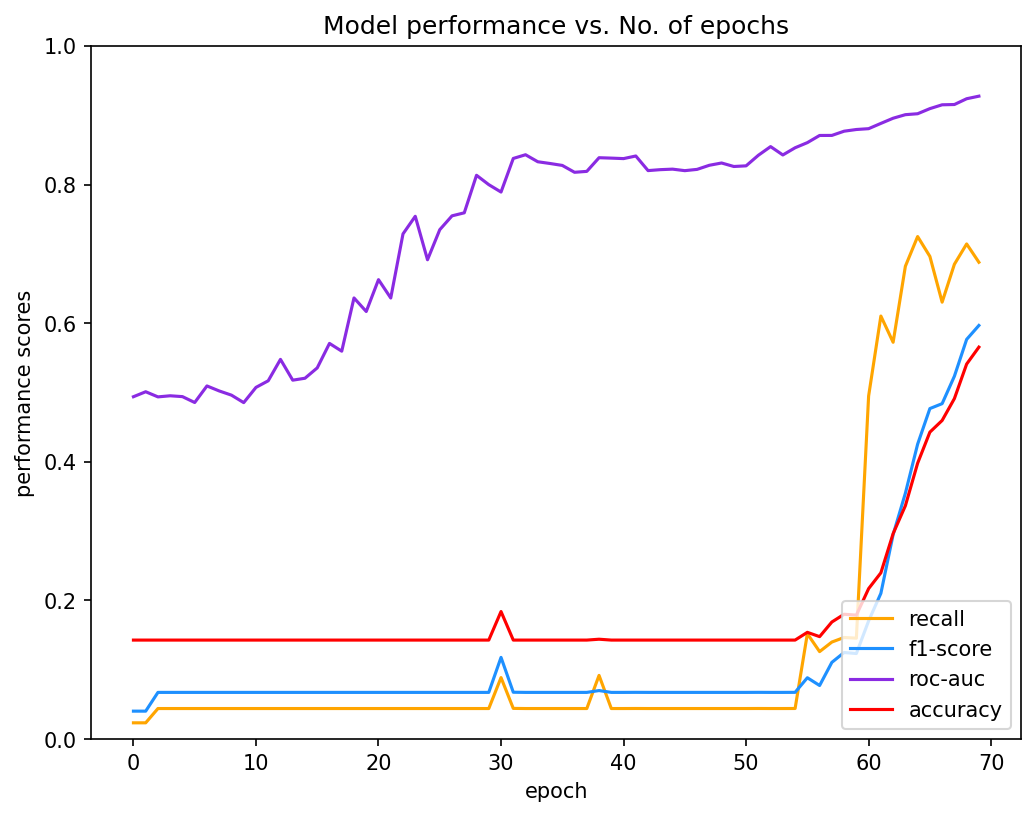

In [ ]:
plot_scores(results)

In [ ]:
model = MNASNet(1.0, 7)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/mnasnetraf.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7224 , roc: 0.9601 , f1: 0.7157 , recall: 0.7667


In [ ]:
# Additional learning TEST

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=40, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 0.7313, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 0.7317, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 0.7332, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 0.7318, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 0.7342, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 0.7344, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 0.7350, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 0.7339, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 0.7355, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 0.7343, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 0.7357, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 0.7326, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 0.7304, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 0.7326, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 0.7321, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 0.7329, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 0.7335, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 0.7322, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 0.7346, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 0.7341, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 0.7311, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 0.7353, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 0.7351, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 0.7288, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 0.7304, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 0.7341, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 0.7321, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 0.7311, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 0.7265, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 0.7299, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 0.7310, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 0.7293, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 0.7338, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 0.7379, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 0.7336, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 0.7353, val_loss: 0.6700, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 0.7300, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 0.7329, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 0.7321, val_loss: 0.6701, val_acc: 0.6824


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.7317, val_loss: 0.6701, val_acc: 0.6824
Training complete in 38m 17s
Best val Acc: 0.682449


In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7694 , roc: 0.964 , f1: 0.766 , recall: 0.7877


In [ ]:
#source for timing the model execution: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
dummy_input = torch.randn(1,1,64,64, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print("Avg prediction time:", round(mean_syn,3), "Sd:", round(std_syn,3))

Avg prediction time: 7.127 Sd: 1.648
